# Localization

Predict a single bounding box per image. Uses the MobileNet-based classifier as the starting point.

**NOTE:** The results in this notebook are similar to those shown in the book but are not 100% the same. Because neural networks are initialized with random numbers, each training session will give slightly different results.

## Load the annotations

In [76]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [77]:
data_dir = "snacks"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [78]:
train_annotations = pd.read_csv(os.path.join(data_dir, "annotations-train.csv"))
train_annotations.head()

,image_id,x_min,x_max,y_min,y_max,class_name,folder
0,009218ad38ab2010,0.192620,0.729831,0.127606,0.662219,cake,cake
1,009218ad38ab2010,0.802377,1.000000,0.102585,0.405338,ice cream,cake
2,009218ad38ab2010,0.814884,0.970607,0.121768,0.357798,ice cream,cake
3,00c7515143b32051,0.135084,0.904315,0.081735,0.909091,cake,muffin
4,00c7515143b32051,0.155722,0.910569,0.083403,0.893244,muffin,muffin


In [79]:
len(train_annotations)

7040

In [80]:
val_annotations = pd.read_csv(os.path.join(data_dir, "annotations-val.csv"))
test_annotations = pd.read_csv(os.path.join(data_dir, "annotations-test.csv"))

In [81]:
len(val_annotations), len(test_annotations)

(1417, 1380)

## Plot training image + its bounding boxes

In [82]:
image_width = 224
image_height = 224

In [83]:
from helpers import plot_image

In [84]:
from tensorflow.keras.preprocessing import image

def plot_image_from_row(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox = (row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"])
    plot_image(img, [bbox])

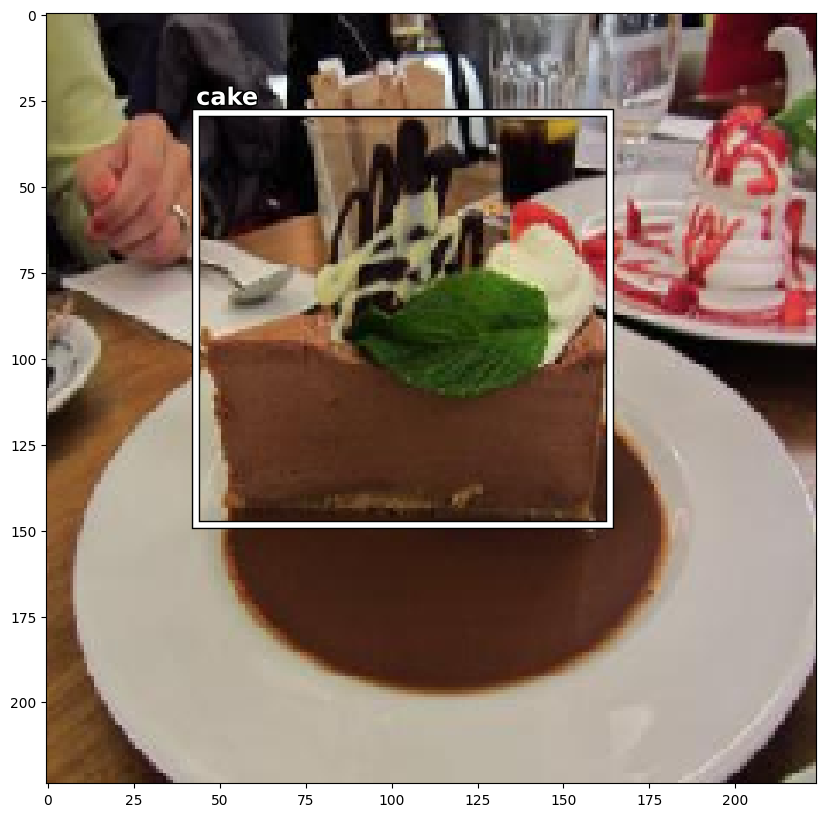

In [85]:
plot_image_from_row(train_annotations.iloc[0], train_dir)

## Custom generator

In [86]:
from helpers import BoundingBoxGenerator


In [87]:
batch_size = 32
train_generator = BoundingBoxGenerator(train_annotations, train_dir, 
                                       image_height, image_width, 
                                       batch_size, shuffle=True)

In [88]:
train_iter = iter(train_generator)
X, (y_class, y_bbox) = next(train_iter)

In [89]:
X.shape, y_class.shape, y_bbox.shape

((32, 224, 224, 3), (32,), (32, 4))

In [90]:
y_bbox

array([[6.95000e-04, 3.50954e-01, 2.72065e-01, 6.38985e-01],
       [1.06416e-01, 9.32707e-01, 2.59781e-01, 8.62285e-01],
       [7.84640e-02, 9.24875e-01, 3.59600e-01, 8.93684e-01],
       [6.47699e-01, 9.79079e-01, 3.45841e-01, 5.31582e-01],
       [4.33333e-01, 8.06667e-01, 5.65000e-01, 8.55000e-01],
       [2.96478e-01, 5.46971e-01, 5.05701e-01, 9.87495e-01],
       [0.00000e+00, 9.99804e-01, 1.71000e-04, 9.99963e-01],
       [0.00000e+00, 7.25907e-01, 0.00000e+00, 7.63158e-01],
       [1.28793e-01, 8.58948e-01, 1.02363e-01, 8.54827e-01],
       [1.76814e-01, 6.72227e-01, 2.82051e-01, 8.17386e-01],
       [2.27017e-01, 4.96560e-01, 3.88657e-01, 5.42952e-01],
       [5.15548e-01, 7.41408e-01, 5.66285e-01, 8.39607e-01],
       [3.88830e-01, 7.12101e-01, 2.54787e-01, 8.14539e-01],
       [8.75550e-02, 7.82364e-01, 1.25104e-01, 9.29942e-01],
       [3.09156e-01, 7.62685e-01, 1.88577e-01, 8.82468e-01],
       [1.36826e-01, 2.70524e-01, 7.92490e-02, 2.53389e-01],
       [2.02586e-01, 4.9

In [ ]:
y_class

In [91]:
from helpers import labels
list(map(lambda x: labels[x], y_class))

['orange',
 'doughnut',
 'cake',
 'doughnut',
 'grape',
 'cookie',
 'salad',
 'doughnut',
 'apple',
 'pineapple',
 'hot dog',
 'strawberry',
 'cake',
 'carrot',
 'juice',
 'orange',
 'watermelon',
 'banana',
 'apple',
 'ice cream',
 'muffin',
 'grape',
 'cake',
 'pretzel',
 'ice cream',
 'doughnut',
 'cookie',
 'banana',
 'doughnut',
 'cookie',
 'banana',
 'hot dog']

In [92]:
len(train_generator)

220

In [93]:
def plot_image_from_batch(X, y_class, y_bbox, img_idx):
    class_name = labels[y_class[img_idx]]
    bbox = y_bbox[img_idx]
    plot_image(X[img_idx], [[*bbox, class_name]])

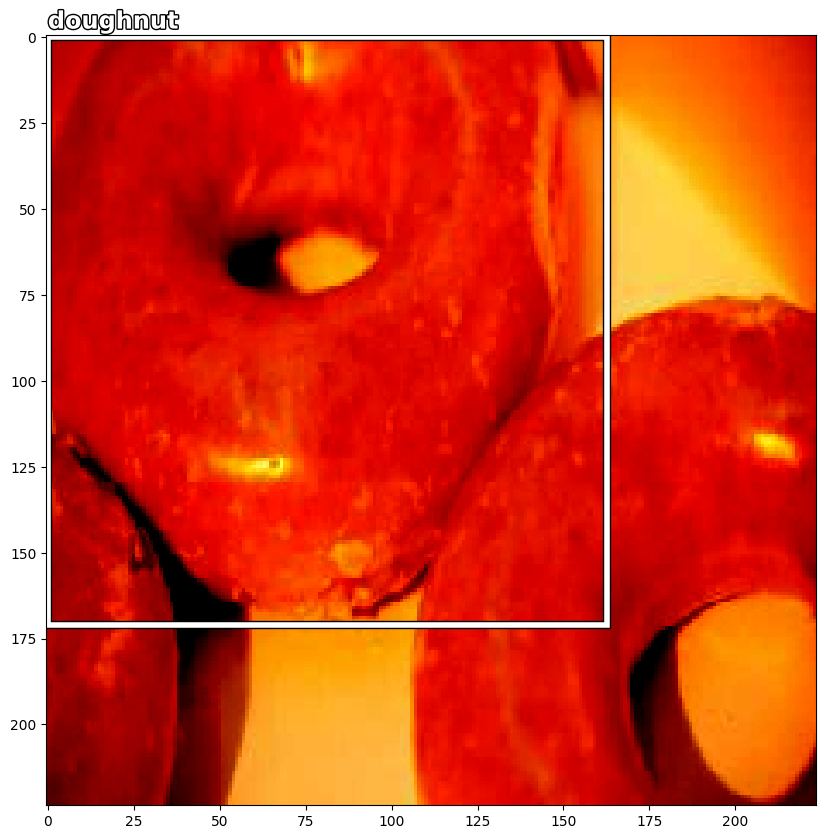

In [94]:
plot_image_from_batch(X, y_class, y_bbox, 7)

In [95]:
X, (y_class, y_bbox) = next(train_iter)

## Load the best model from last time

In [96]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.models import Model, load_model
from keras import optimizers, callbacks
from tensorflow.python.keras import regularizers
import keras.backend as K

classifier_model = load_model("checkpoints/multisnacks-0.7162-0.8419.hdf5")

In [97]:
classifier_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 20)                20500     
                                                                 
 activation_3 (Activation)   (None, 20)                0         
                                                                 
Total params: 3,249,364
Trainable params: 3,227,476
No

## Add the bounding box predictor to the model

In [98]:
num_classes = 20

# The MobileNet feature extractor is the first "layer".
base_model = classifier_model.layers[0]

# Add a global average pooling layer after MobileNet.
pool = GlobalAveragePooling2D()(base_model.outputs[0])

# Reconstruct the classifier layers.
clf = Dropout(0.7)(pool)
clf = Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), name="dense_class")(clf)
clf = Activation("softmax", name="class_prediction")(clf)

# Add new layers for the bounding box predictor.
bbox = Conv2D(512, 3, padding="same")(base_model.outputs[0])
bbox = BatchNormalization()(bbox)
bbox = Activation("relu")(bbox)
bbox = GlobalAveragePooling2D()(bbox)
bbox = Dense(4, name="bbox_prediction")(bbox)

# Create the new model.
model = Model(inputs=base_model.inputs, outputs=[clf, bbox])

In [99]:
for layer in base_model.layers:
    layer.trainable = False

In [100]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [101]:
from keras.utils import plot_model
plot_model(model, to_file="bbox_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Put the old weights back, or the classifier won't work anymore:

In [102]:
layer_dict = {layer.name:i for i, layer in enumerate(model.layers)}

# Get the weights from the checkpoint model.
weights, biases = classifier_model.layers[-2].get_weights()

# Put them into the new model.
model.layers[layer_dict["dense_class"]].set_weights([weights, biases])

In [ ]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[1.0, 10.0],
              optimizer=optimizers.Adam(lr=1e-3),
              metrics={ "class_prediction": "accuracy" })

## Try the model on an image

In [ ]:
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image

img = image.load_img(train_dir + "/salad/2ad03070c5900aac.jpg", target_size=(image_width, image_height))
img

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
preds

In [ ]:
len(preds)

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), preds[0].squeeze())
plt.xticks(range(num_classes), labels, rotation=90, fontsize=20)
plt.show()

In [ ]:
preds = classifier_model.predict(x)
preds

In [ ]:
preds = model.predict_generator(train_generator)

In [ ]:
preds[1].shape

## Train the model

In [ ]:
val_generator = BoundingBoxGenerator(val_annotations, val_dir, 
                                     image_height, image_width, 
                                     batch_size, shuffle=False)

In [ ]:
from helpers import combine_histories, plot_loss, plot_bbox_loss

In [ ]:
histories = []

In [ ]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

In [ ]:
history = combine_histories(histories)
plot_loss(history)

In [ ]:
plot_bbox_loss(history)

## Adding the IOU metric

In [ ]:
from helpers import iou, MeanIOU, plot_iou

bbox1 = [0.2, 0.7, 0.3, 0.6, "bbox1"]
bbox2 = [0.4, 0.6, 0.2, 0.5, "bbox2"]
iou(bbox1, bbox2)

In [ ]:
plot_image(img, [bbox1, bbox2])

**NOTE:** At this point I went back to the beginning of the notebook and created the model again. That way you can see clearer how the mean IOU increases over time. Just run all the cells from the section **Add the bounding box predictor to the model** again, then come back here. 

In [ ]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[1.0, 10.0],
              optimizer=optimizers.Adam(lr=1e-3),
              metrics={ "class_prediction": "accuracy", 
                        "bbox_prediction": MeanIOU().mean_iou })

In [ ]:
histories = []

In [ ]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

In [ ]:
K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) / 10)

In [ ]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

In [ ]:
history = combine_histories(histories)
plot_loss(history)

In [ ]:
plot_bbox_loss(history)

In [ ]:
plot_iou(history)

## Try the model on the test set

In [ ]:
def plot_prediction(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox_true = [row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"].upper()]
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    bbox_pred = [*pred[1][0], labels[np.argmax(pred[0])]]
    
    plot_image(img, [bbox_true, bbox_pred])
   
    print("IOU:", iou(bbox_true, bbox_pred))

In [ ]:
row_index = np.random.randint(len(test_annotations))
row = test_annotations.iloc[row_index]
plot_prediction(row, test_dir)

In [ ]:
import coremltools
coreml_model = coremltools.convert(model,
                     inputs=[coremltools.TensorType(dtype=np.float16)],
                     minimum_deployment_target=coremltools.target.iOS16)
# coreml_model = coremltools.converters.convert(
#     best_model,
#     input_names="image",
#     image_input_names="image",
#     output_names="labelProbability",
#     predicted_feature_name="label",
#     red_bias=-1,
#     green_bias=-1,
#     blue_bias=-1,
#     image_scale=2/255.0,
#     class_labels=labels)

coreml_model.save("my_net.mlpackage")

coreml_model1 = coremltools.convert(classifier_model,
                     inputs=[coremltools.TensorType(dtype=np.float16)],
                     minimum_deployment_target=coremltools.target.iOS16)

coreml_model1.save("my_net1.mlpackage")

